### This notebook goes over how to access and load in CMIP6 data from the Google Cloud Storage (GCS), using full-depth ocean potential temperature model output from GFDL-ESM4.

__Author__: Dr. Beadling. For any questions regarding the contents of this notebook please contact rebecca.beadling@temple.edu.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr  # to read in Zarr format
import gcsfs # to read google cloud data
import momlevel as ml
import cftime
import cmocean


In [2]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

### The CMIP6 data stored in the Google Cloud Storage are derived from the original CMIP6 data files distributed via the Earth System Grid Federation (ESGF) (https://esgf-node.llnl.gov/projects/cmip6/).The CMIP6 hosted on Google Cloud are maintained by the Climate Data Science Lab at Lamont Doherty Earth Observatory (LDEO) of Columbia University, as part of the Pangeo Project .

### The CMIP6 dataset in Google Cloud Storage is publically available and free to use. 

### The code below reads in a `.csv` file that contains the CMIP6 data catalog stored in the Google Cloud. We can read this in as a __Pandas DataFrame__. 

In [3]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [4]:
google_cloud_cmip6

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
523769,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523770,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523771,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523772,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207


### The CMIP6 data on Google Cloud is organized by the following:
* ### __activity_id__: The Model Intercomparison Project (MIP) activity. __CMIP__ is where the standard DECK experiments are (i.e., piControl, historical, 1pctCO2, etc). __ScenarioMIP__ is where the SSP scenario simulation output is.
* ### __institution_id__: The name of the institution or modeling center where the model comes from. A list of institution_ids can be found [here](https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_institution_id.html) (Make sure to show 500 entries!)
* ### __source_id__: The name of the climate model. A table of all models participating in CMIP6 can be found [here](https://airtable.com/appYNLuWqAgzLbhSq/shrvRybShvNSE1Szp/tblC0DBPiCm7gjJqx).
* ### __experiment_id__: The climate model experiment name.
* ### __member_id__: The individual ensemble member.
* ### __table_id__: Specifying realm (atmosphere, ocean, ice, land, etc) and frequency of output (hourly, daily, monthly, annual ... etc): Click [here](https://docs.google.com/spreadsheets/d/1Hmu9fE9GdXUZoTl90vDv-qiI803L2feMxe6dAR0oErI/edit#gid=110419801) for a list and description of of all the possible __table ids__.
* ### __variable_id__: The name of the climate variables the models output. Some of these short names are very hard to discern unless you are very familiar with CMIP. Please see the table [here](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271) for all the possible variable names.
* ### __grid_label__: a key indicating if the model output is on the model's native grid or if regridded.
- grid_label = "gn" (output is reported on the native grid)
- grid_label = "gr" (output is not reported on the native grid, but instead is regridded by the modeling group)
- grid_label = “gm” (global mean output is reported, so data are not gridded)


* ### __z_store__: The path to the Zarr store where the data is stored.


### <span style="color:red"> Investigating the archive using the links above answer the following questions:
### <span style="color:red"> 1) How many individual climate models contributed simulations to CMIP6?
### <span style="color:red"> 2) If you wanted to analyze regridded monthly ocean _potential temperature_ ("sea water potential temperature") from the SSP5-85 simulation carried out by GFDL-ESM4, fill out the following information you would need:
    activity_id: 
    institution_id: 
    source_id:
    experiment_id: ssp585
    member_id: r1i1p1f1
    table_id:
    variable_id:
    grid_label:


130 models contributed.

activity_id: CMIP
    institution_id: NOAA-GFDL
    source_id:GFDL-ESM4
    experiment_id: ssp585
    member_id: r1i1p1f1
    table_id:Omon
    variable_id:thetao
    grid_label: gr

## We can use the information above and Pandas' `.query()` method to filter through the CMIP6 archive to load in the Dataset we need:

In [5]:
gfdl_esm4_thetao_data = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Omon' & \
    variable_id == 'thetao' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr' & \
    member_id == 'r1i1p1f1'"
)

In [6]:
gfdl_esm4_thetao_data

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
12095,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701


## Great, so now that we have the Dataset we want ... how do we load it in?? We can load in the Zarr store that we've isolated above using `gcsfs`, `zarr`, and `xarray`.

In [7]:
# this only needs to be created once per Jupyter session
gcs = gcsfs.GCSFileSystem(token='anon')

## The code below retrieves the path to a specific zarr store (the first one from the dataframe above)

In [8]:
zstore_esm4_thetao = gfdl_esm4_thetao_data.zstore.values[-1]

In [9]:
zstore_esm4_thetao

'gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Omon/thetao/gr/v20180701/'

## The code below creates a mutable-mapping-style interface to the zarra store and then loads in the Dataset using __xarray's__ `xr.open_zarr()` method. In the same line of code where we load in the Dataset we can also extract the array and rename some variables for consistency:

In [10]:
# create a mutable-mapping-style interface to the store
mapper_esm4_thetao = gcs.get_mapper(zstore_esm4_thetao)
# open the dataset using xarray and zarr
gfdl_esm4_thetao = xr.open_zarr(mapper_esm4_thetao, 
                                consolidated=True,use_cftime=True).thetao.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_esm4_thetao

<xarray.DataArray 'thetao' (time: 1032, lev: 35, latitude: 180, longitude: 360)>
dask.array<open_dataset-thetao, shape=(1032, 35, 180, 360), dtype=float32, chunksize=(13, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Sea Water Potential Temperature
    original_name:  thetao
    standard_name:  sea_water_potential_temperature
    units:          degC

## Take a moment to become acquainted with DataArray you've just loaded in. <span style="color:red"> How many dimensions are there? What are their names? What are their coordinate labels? Then, in the code below, write code that would produce a plot of sea surface temperature for the first time slice ('2015-01-16').

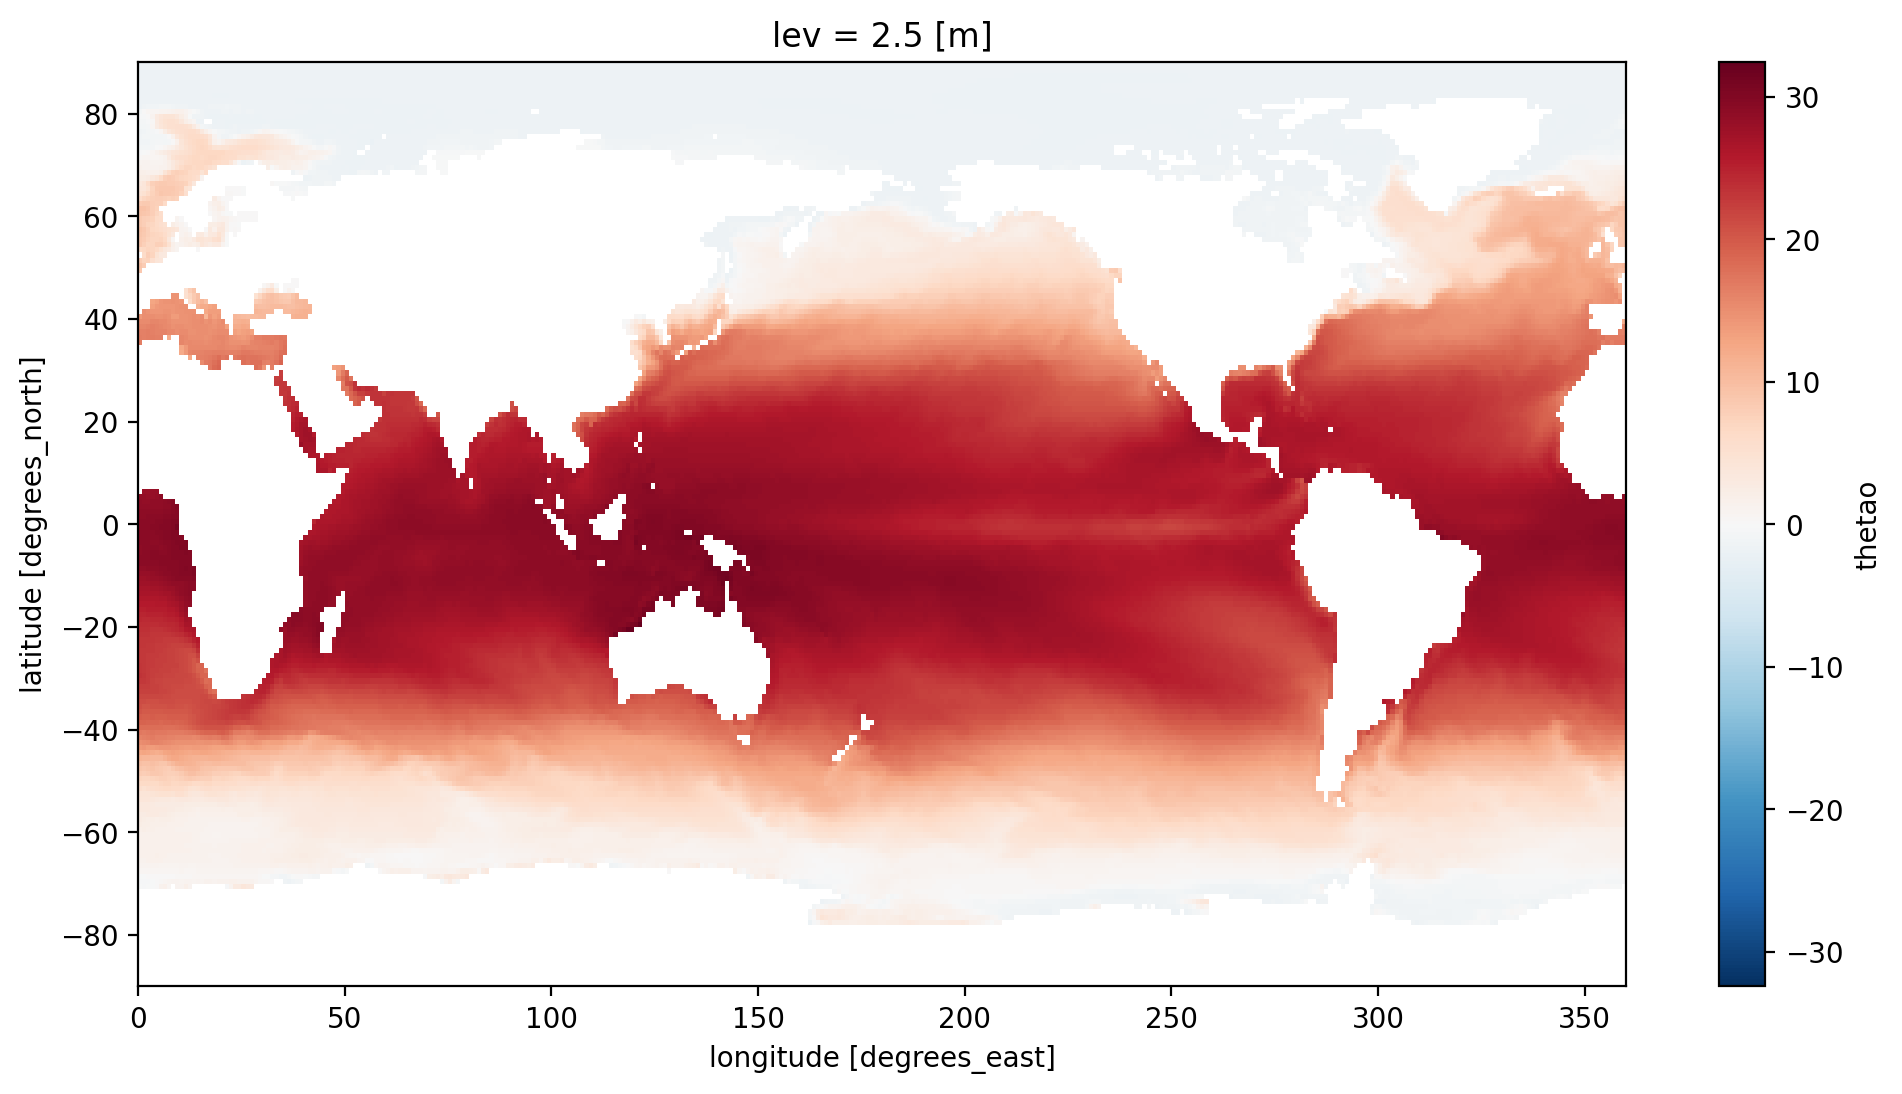

In [11]:
gfdl_esm4_thetao.sel(time= '2015-01-16').sel(lev= 2.5).mean(dim='time').plot()

## <span style="color:red"> Okay, now write code in the cell below that produces a time-average of the full-depth data spanning years 2015 to 2025 and a time-average of years 2081 to 2100 (**hint .... you've already done this in a previous project).

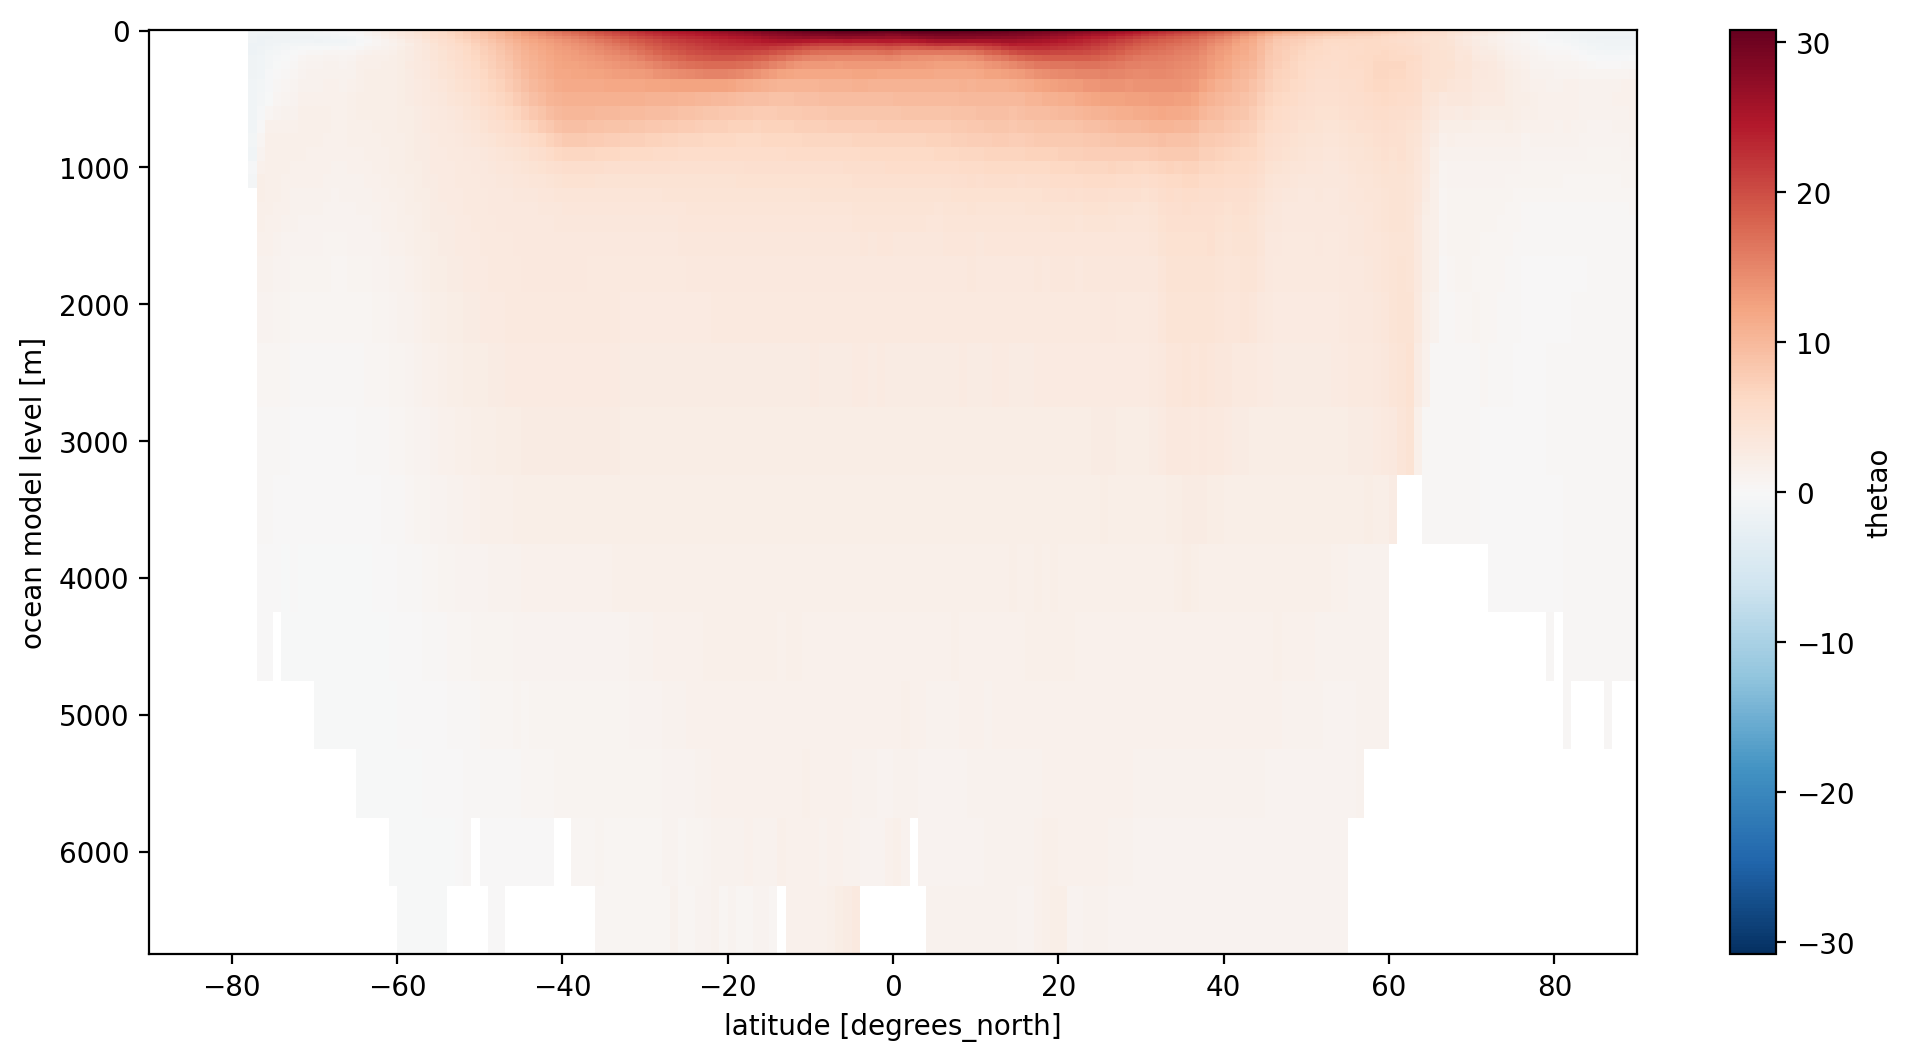

In [36]:
esm4_temp_15_25 = gfdl_esm4_thetao.sel(time=slice('2015-01-16','2025-12-16')).mean(dim='time')
## do the same thing below but for the last 20 years.
esm4_temp_81_100 = gfdl_esm4_thetao.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time').mean(dim='longitude')
esm4_temp_81_100.plot(yincrease=False)

## <span style="color:red"> Okay, now compute the difference as last period minus first period:

In [27]:
slice1= gfdl_esm4_thetao.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time').mean(dim= 'longitude')

In [28]:
slice2=gfdl_esm4_thetao.sel(time=slice('2015-01-16','2025-12-16')).mean(dim='time').mean(dim= 'longitude')

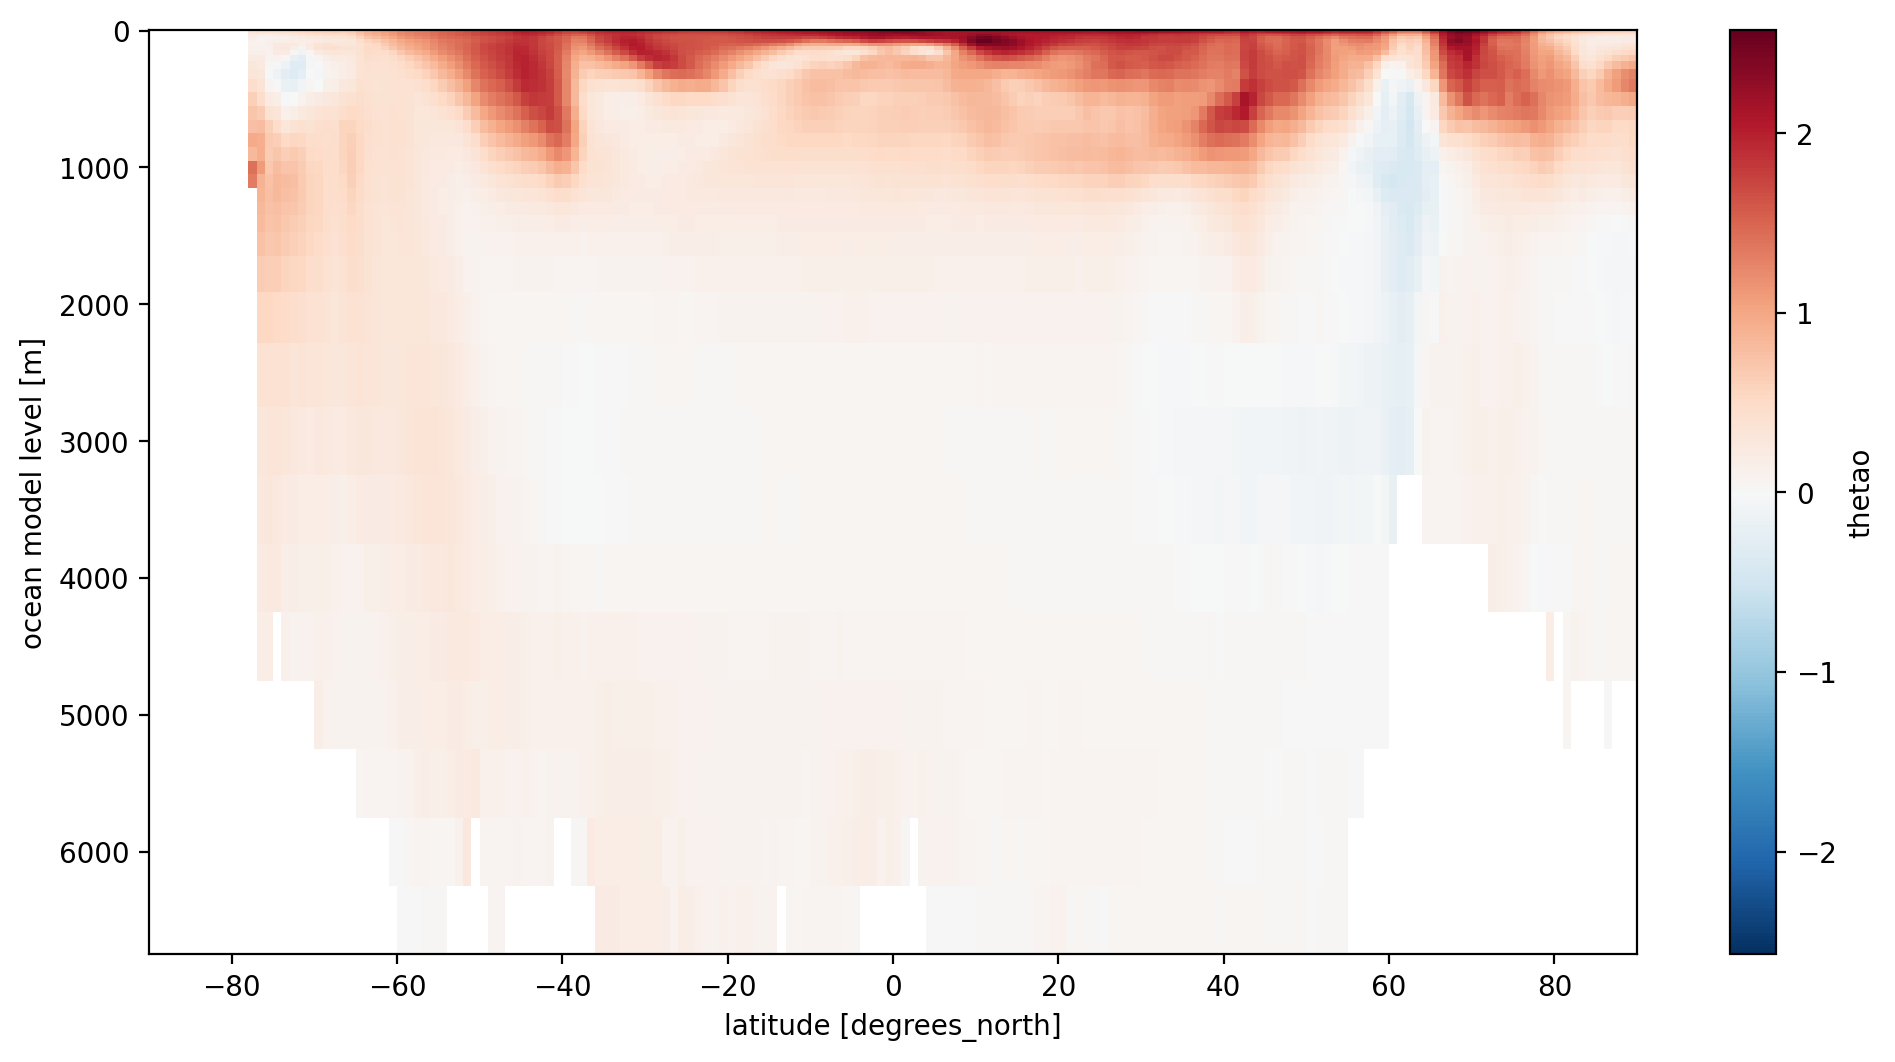

In [30]:
difference_esm4 = slice1-slice2

difference_esm4.plot(yincrease= False)





### Examining your surface plot above tells you that our longitudes span 0 to 360, so if we want 24 W, this is equivalent to 360 - 24 = 336. <span style="color:red"> Knowing this, write code in the cell below that plots the difference in ocean temperature along longitude=336 using `.sel(longitude=336, method='nearest')` and using the cmocean.cm.balance colormap:

In [16]:
slice1_24= gfdl_esm4_thetao.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time').sel(longitude=336, method='nearest')

In [17]:
slice2_24=gfdl_esm4_thetao.sel(time=slice('2015-01-16','2025-12-16')).mean(dim='time').sel(longitude=336, method='nearest')

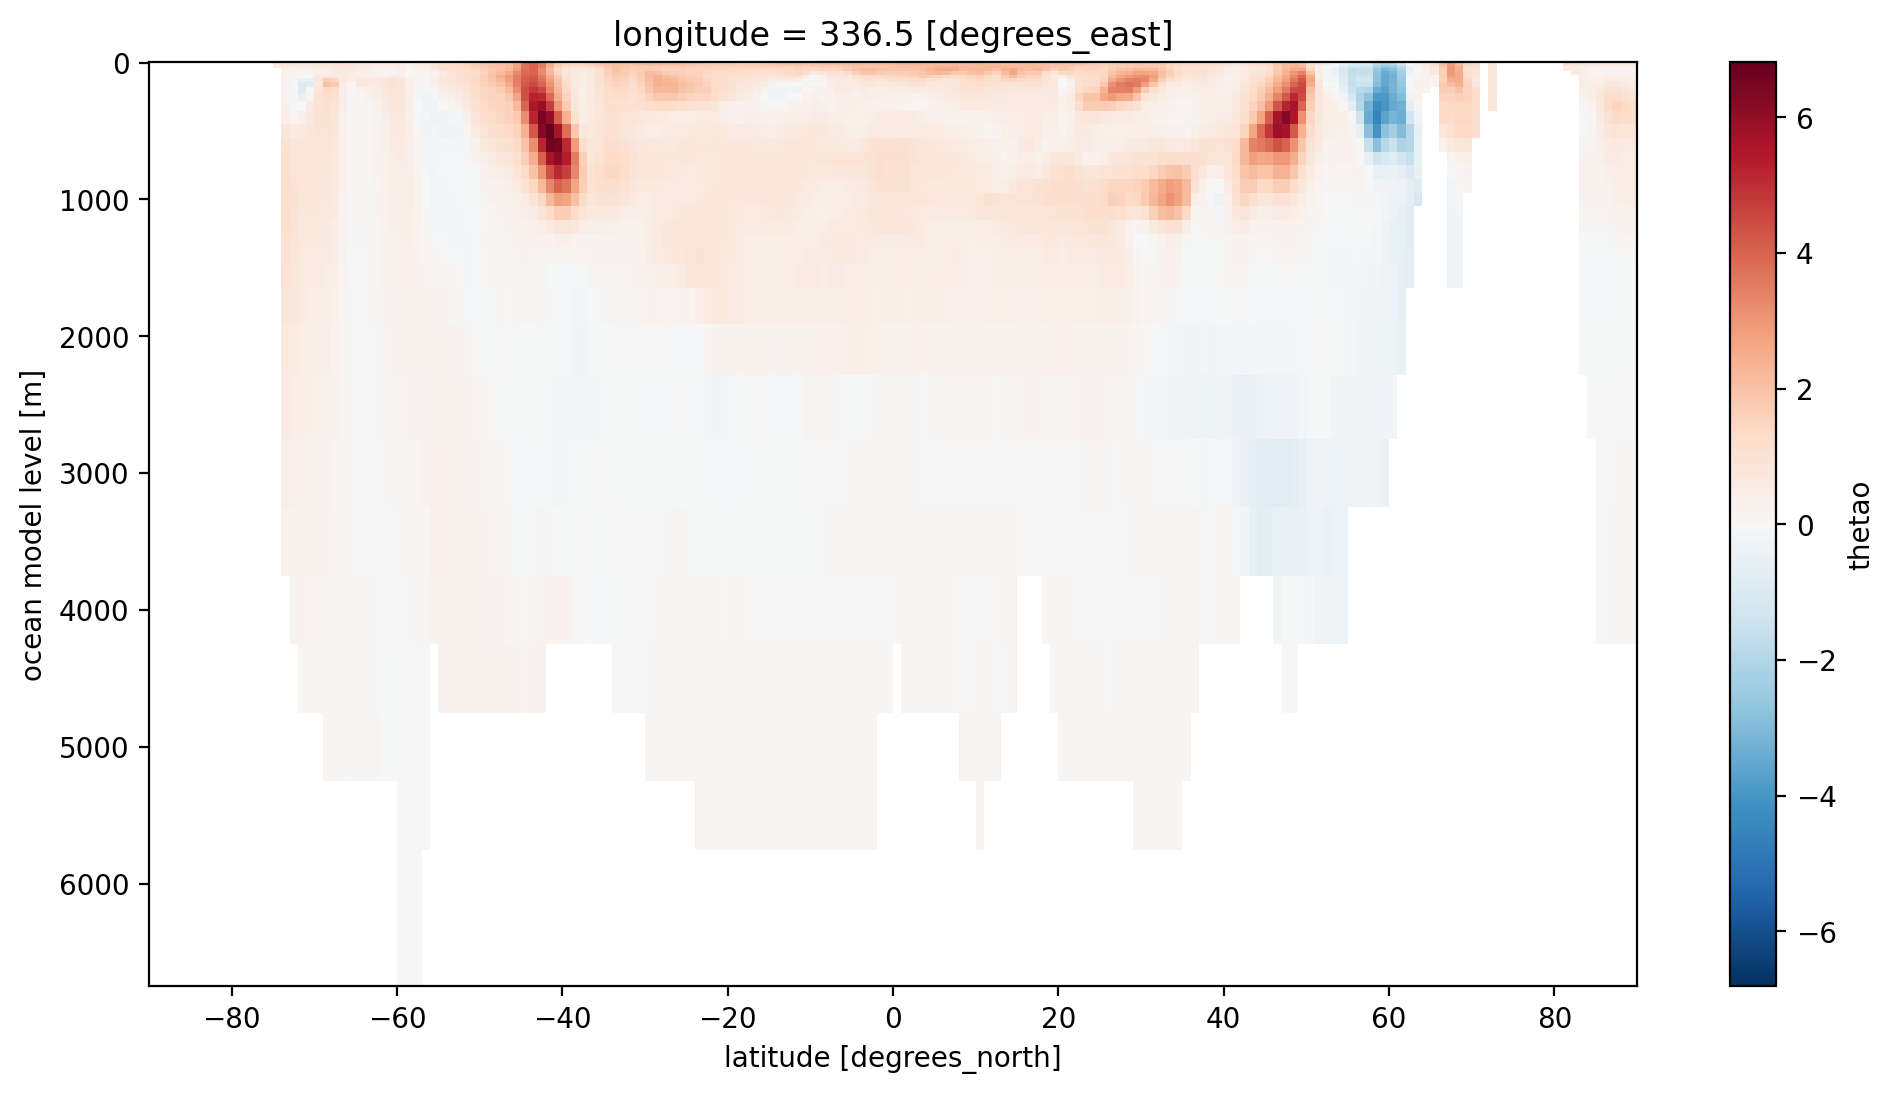

In [18]:
difference_24= slice1_24-slice2_24
difference_24.plot(yincrease= False)

### <span style="color:red"> Repeat the steps above, but instead of plotting the temperature difference along a specific transect, plot the __full zonal average__.

In [19]:
slice1_zave= gfdl_esm4_thetao.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time').mean(dim= 'longitude')

In [20]:
slice2_zave=gfdl_esm4_thetao.sel(time=slice('2015-01-16','2025-12-16')).mean(dim='time').mean(dim='longitude')

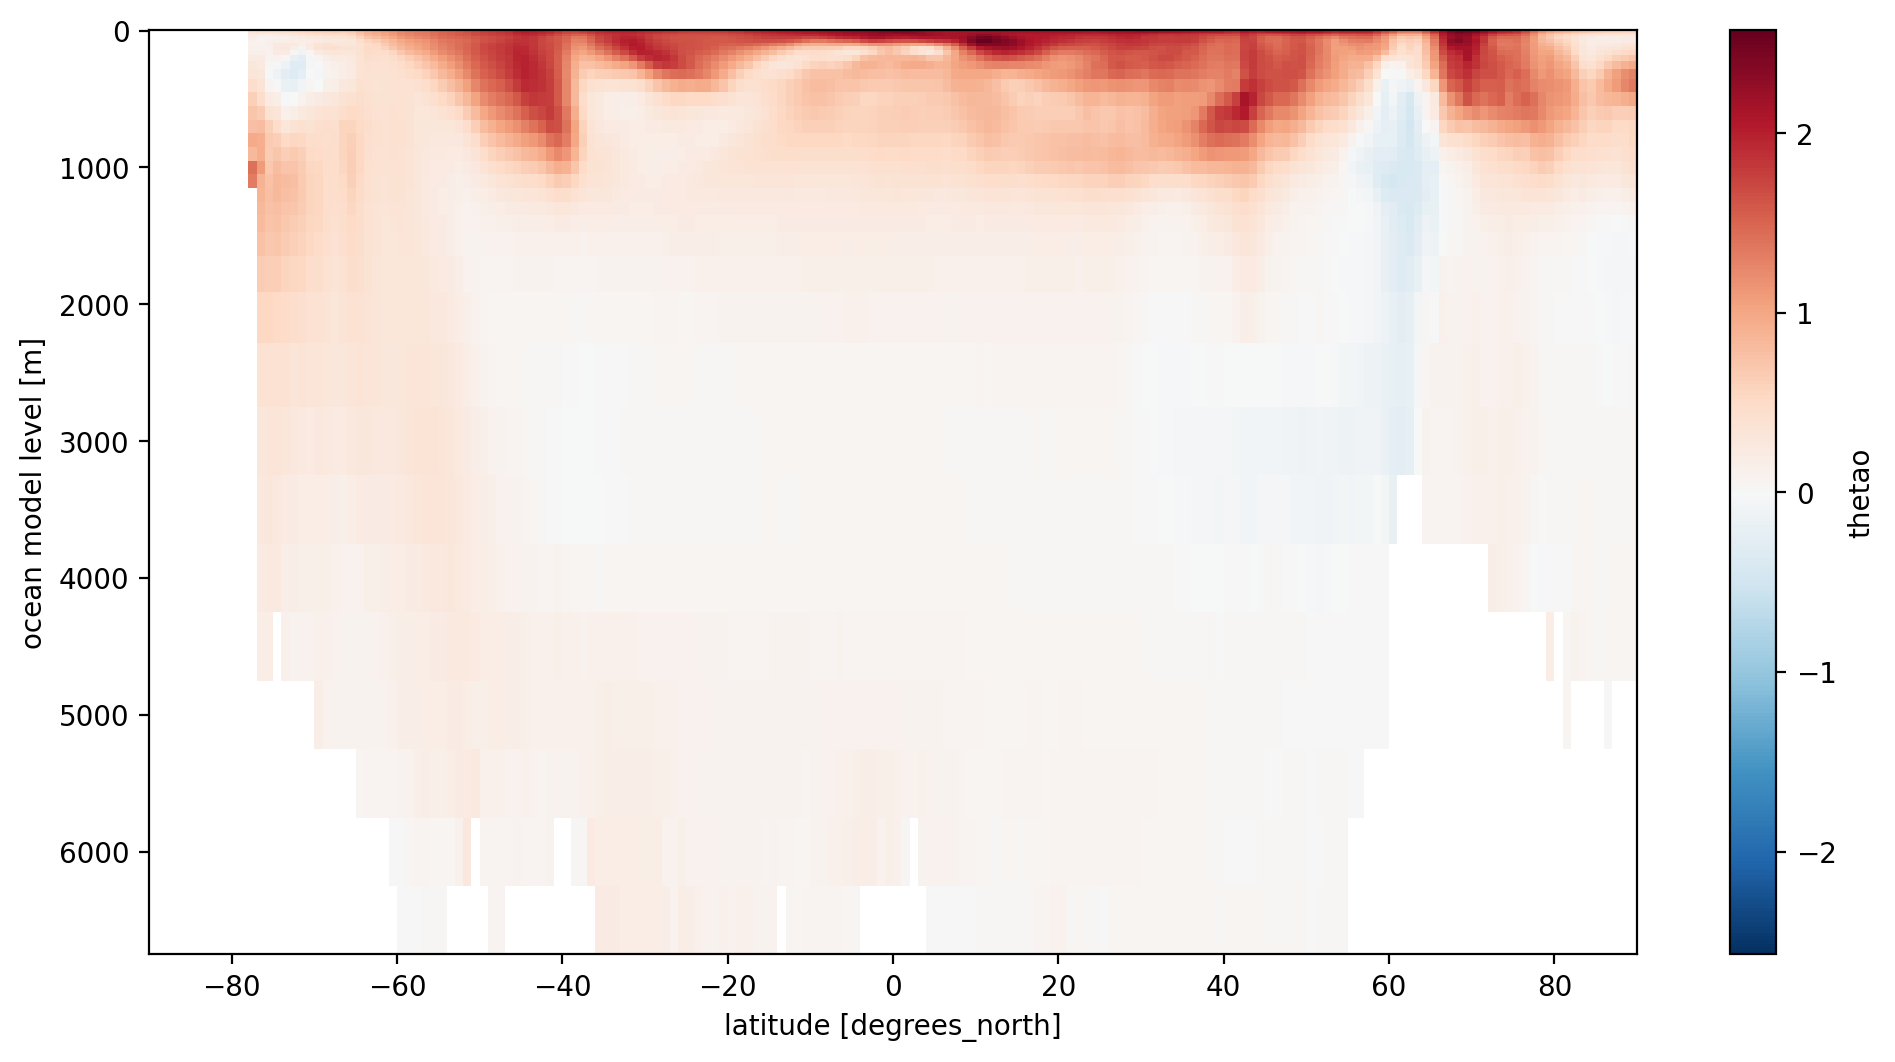

In [21]:
difference_zave= slice1_zave-slice2_zave
difference_zave.plot(yincrease=False)

### The following code produce a plot of the zonally-averaged ocean temperature over the first 20 years,  and the difference.

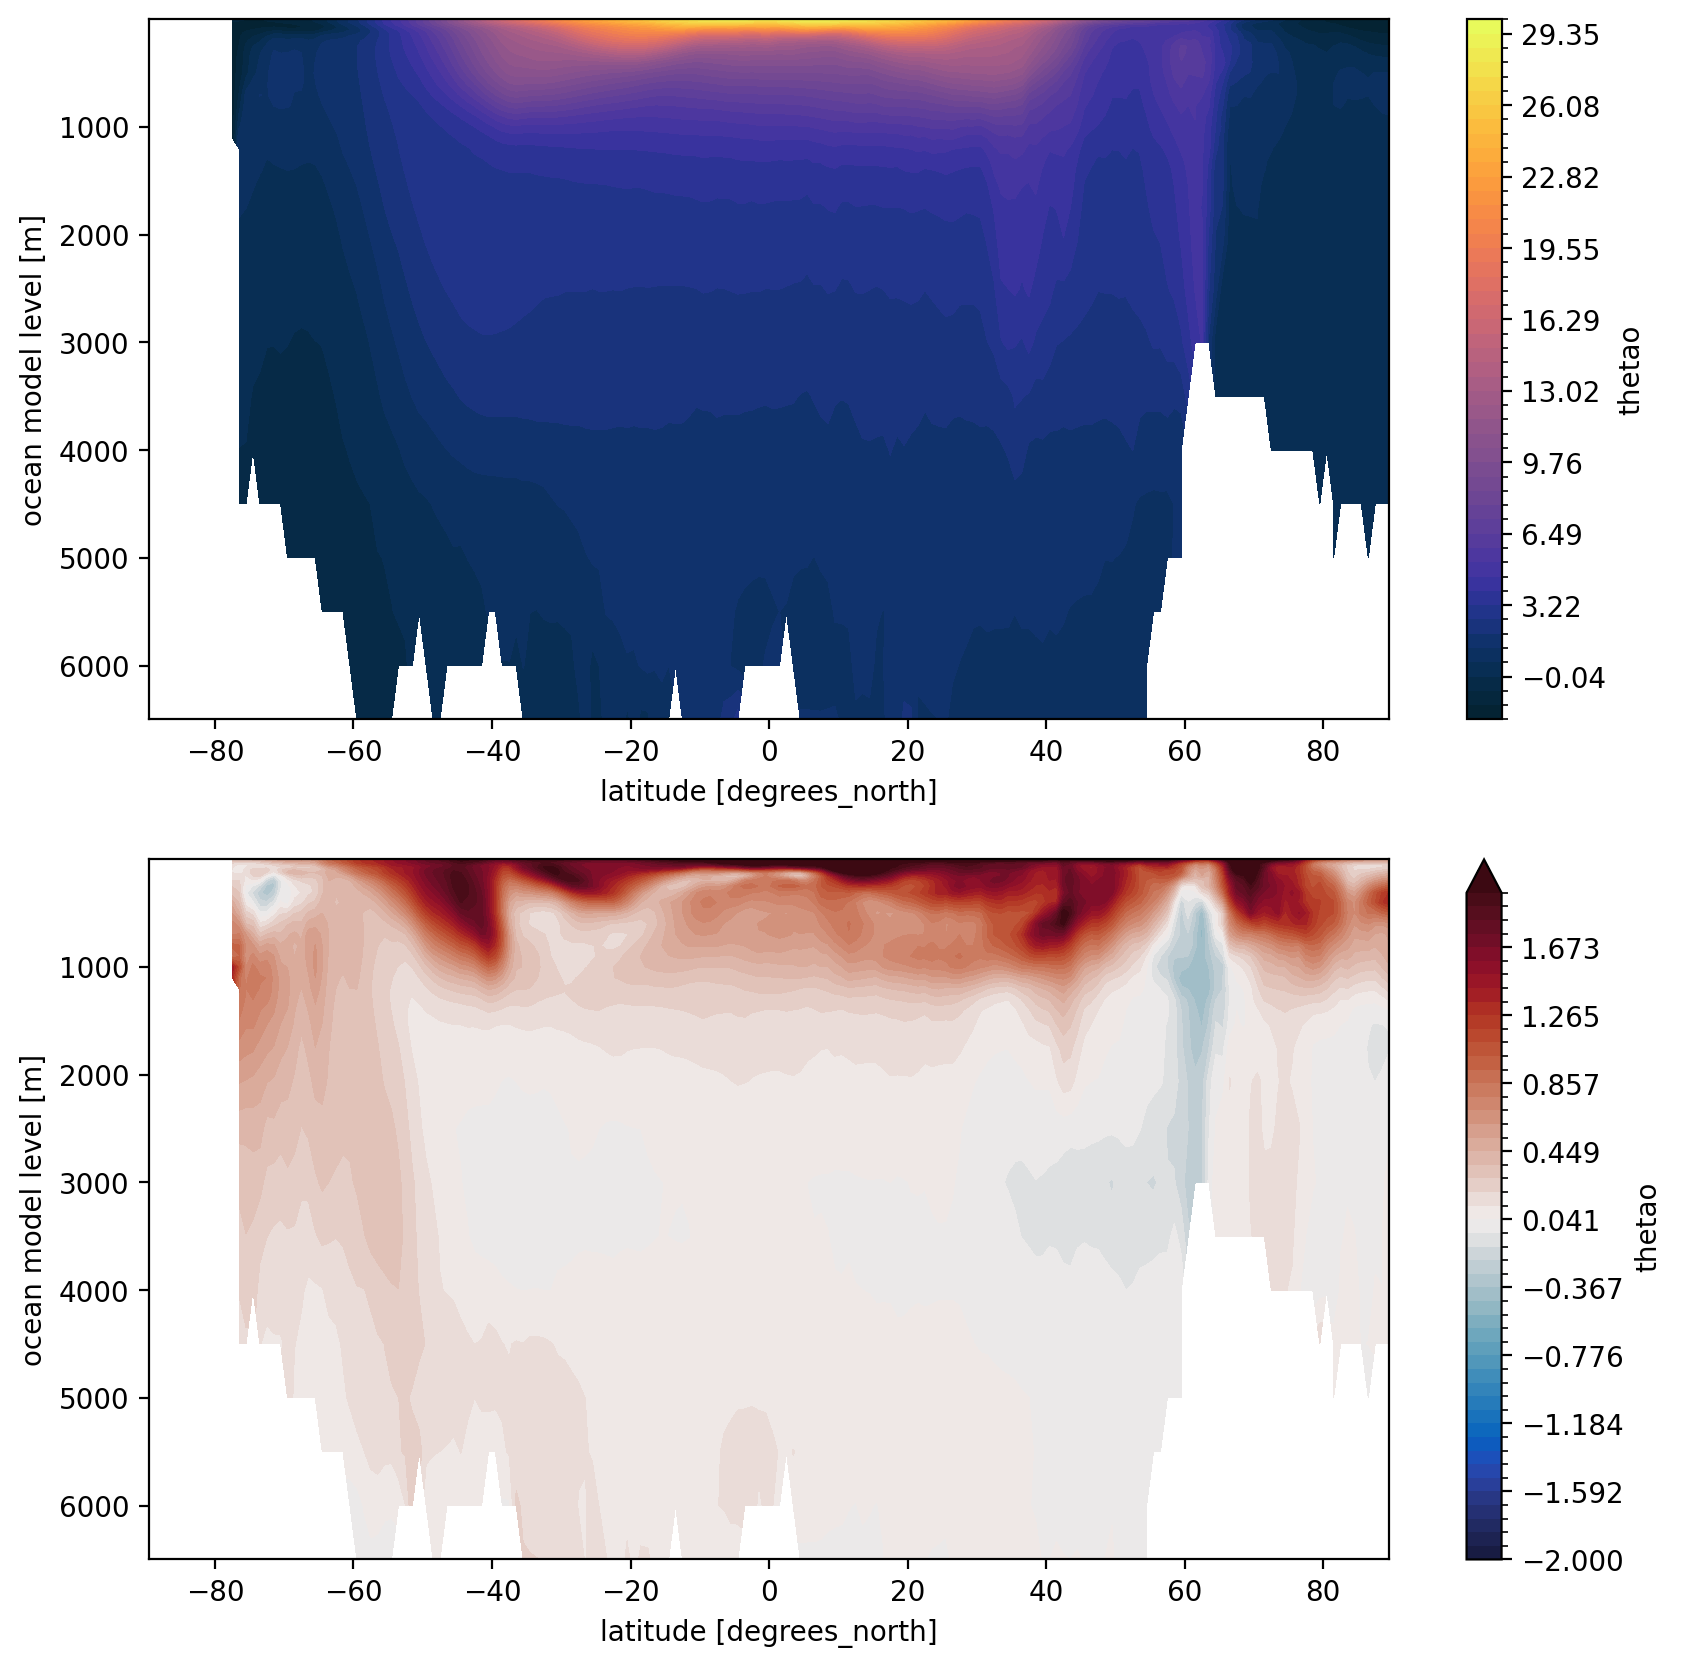

In [31]:
fig, (ax0,ax1) = plt.subplots(ncols=1,nrows=2,figsize=(10,10))

esm4_temp_15_25.mean(dim='longitude').plot.contourf(ax=ax0, yincrease=False,
                                                    levels=50, vmin=-2,vmax=30, cmap=cmocean.cm.thermal)

difference_esm4.plot.contourf(ax=ax1, yincrease=False,
                                                    vmin=-2,vmax=2,
                                                    levels=50, cmap=cmocean.cm.balance)

### <span style="color:red"> In the cells below, describe how the zonally-averaged distribution of temperature changes from the end of the century relative to the start. Where does most of the heat uptake occur?

Most of the heat uptake occurs in the top 1000m of the ocean

### The following code is modified from above to now read in ssp245 data (medium emission scenario)

In [34]:
gfdl_esm4_thetao_data_ssp245 = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Omon' & \
    variable_id == 'thetao' & \
    experiment_id == 'ssp245' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr' & \
    member_id == 'r1i1p1f1'"
)

zstore_esm4_thetao_ssp245 = gfdl_esm4_thetao_data_ssp245.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_esm4_thetao_ssp245 = gcs.get_mapper(zstore_esm4_thetao_ssp245)
# open the dataset using xarray and zarr
gfdl_esm4_thetao_ssp245 = xr.open_zarr(mapper_esm4_thetao_ssp245, 
                                consolidated=True,use_cftime=True).thetao.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_esm4_thetao_ssp245

<xarray.DataArray 'thetao' (time: 1032, lev: 35, latitude: 180, longitude: 360)>
dask.array<open_dataset-thetao, shape=(1032, 35, 180, 360), dtype=float32, chunksize=(13, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Sea Water Potential Temperature
    original_name:  thetao
    standard_name:  sea_water_potential_temperature
    units:          degC

### Repeat the excercise above:
### Compute the difference in zonally-averaged ocean temperature as the last-twenty year average minus the first. How does this differ to the plot you created above for the SSP585 scenario?

In [46]:
slice1_zave= gfdl_esm4_thetao_ssp245.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time').mean(dim= 'longitude')
slice2_zave=gfdl_esm4_thetao_ssp245.sel(time=slice('2015-01-16','2025-12-16')).mean(dim='time').mean(dim='longitude')

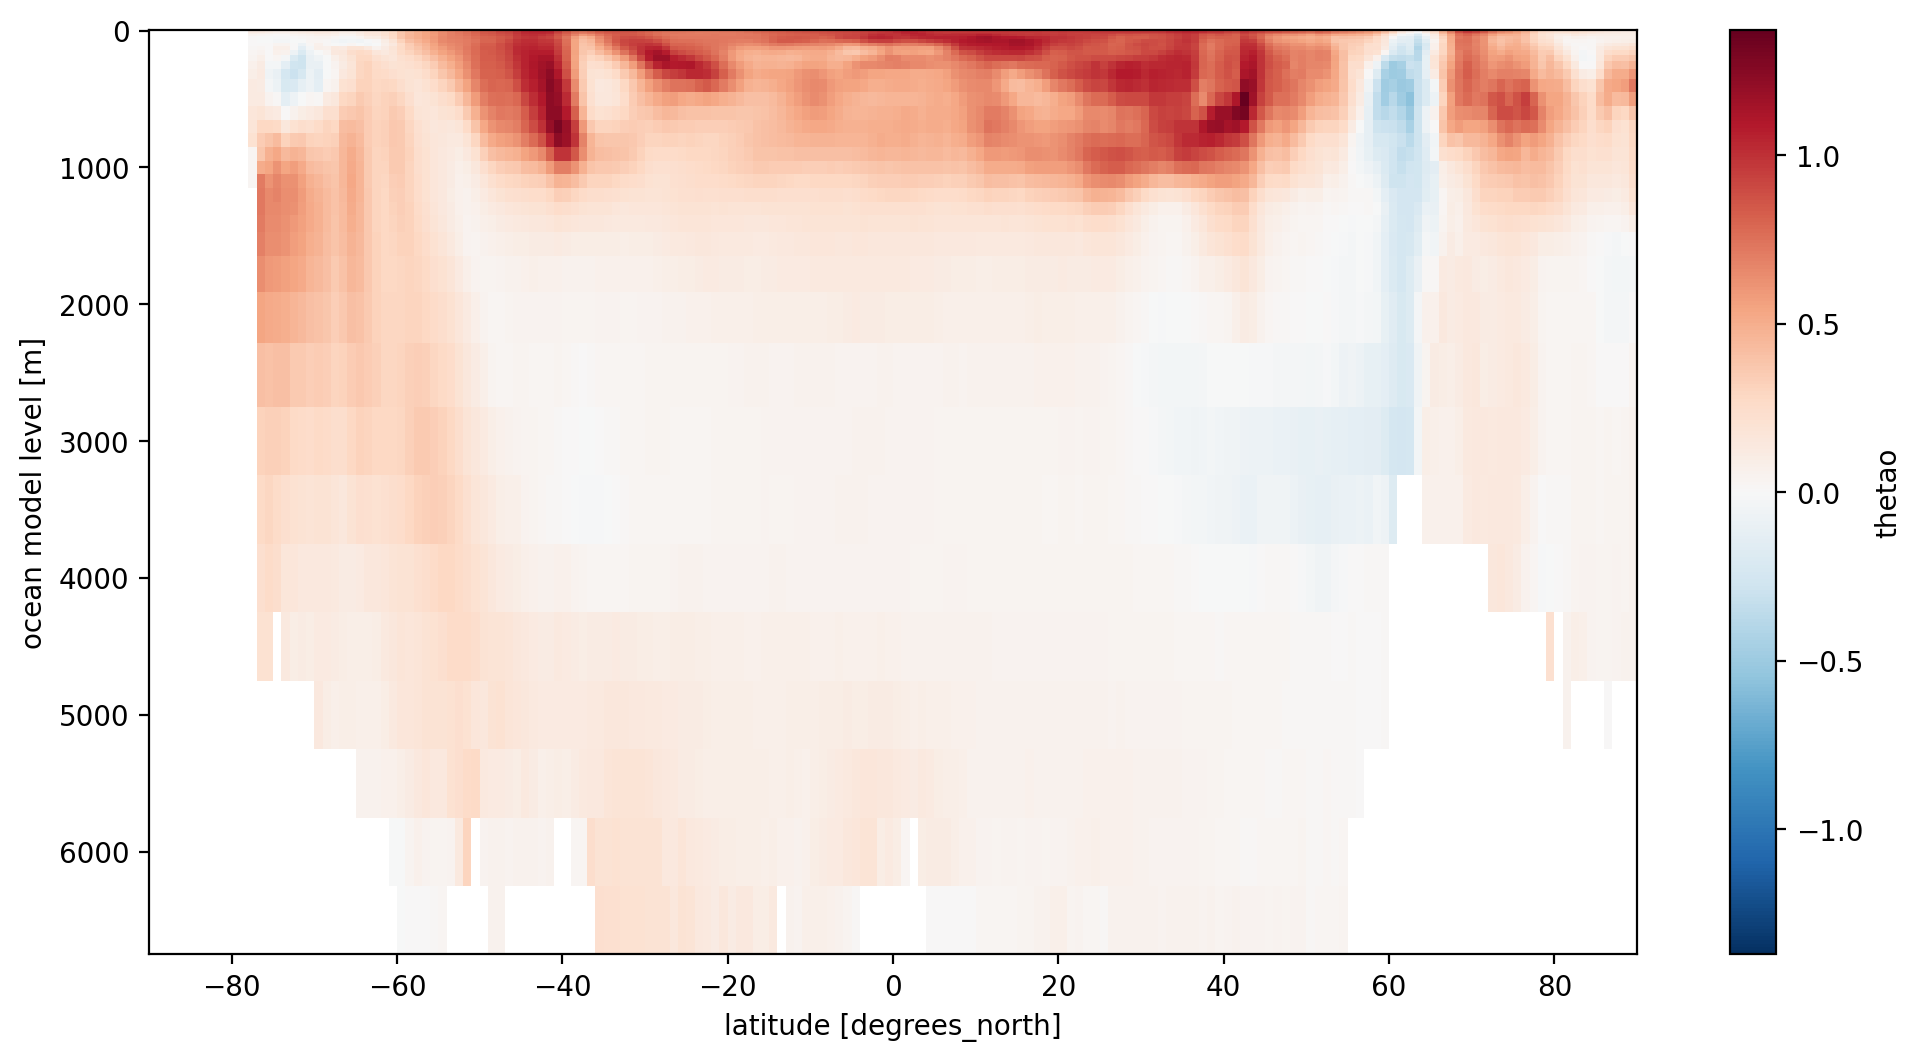

In [48]:
newdifference_esm4 = slice1_zave-slice2_zave

newdifference_esm4.plot(yincrease= False)

